In [1]:
from extract_features import *

import matplotlib.pyplot as plt
import cv2

import sys, os, time
sys.path.insert(0, '../../')
import common.feature_matching as matching

In [2]:
model_names = ['d2_tf.pth', 'd2_ots.pth', 'd2_tf_no_phototourism.pth']
model_num = 2
model = d2net_interface(model_file=os.path.join('../../data/teacher_models/d2net/', model_names[model_num]))

In [3]:
image1 = imageio.imread('../../data/AachenDayNight/images_upright/db/1.jpg')
image2 = imageio.imread('../../data/AachenDayNight/images_upright/db/2.jpg')

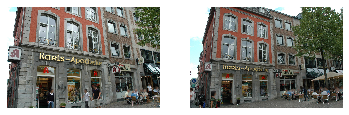

In [4]:
fig = plt.figure()
ax = fig.add_subplot(121)
plt.imshow(image1)
plt.axis('off')
ax = fig.add_subplot(122)
plt.imshow(image2)
plt.axis('off')
plt.show()

In [5]:
k, d, _ = model.extract_features([image1, image2], only_path=False, multiscale=True)

In [7]:
matching_type = 'approx_torch' # choices = ['OpenCV', 'approx_torch', 'approx']
ratio_thresh = .75
local_matcher = matching.LocalMatcher(ratio_thresh, matching_type, False)

In [8]:
matches = local_matcher.match(d[0], d[1])
print('{} matches found'.format(matches.shape[0]))

337 matches found


In [9]:
matches_to_cv = lambda matches: [cv2.DMatch(_queryIdx=m[1], _trainIdx=m[0], _imgIdx=0, _distance=1.0) for m in matches]
kpts_to_cv = lambda kpts: [cv2.KeyPoint(x=kpt[0], y=kpt[1], _size=1.0) for kpt in kpts]

(-0.5, 3199.5, 1062.5, -0.5)

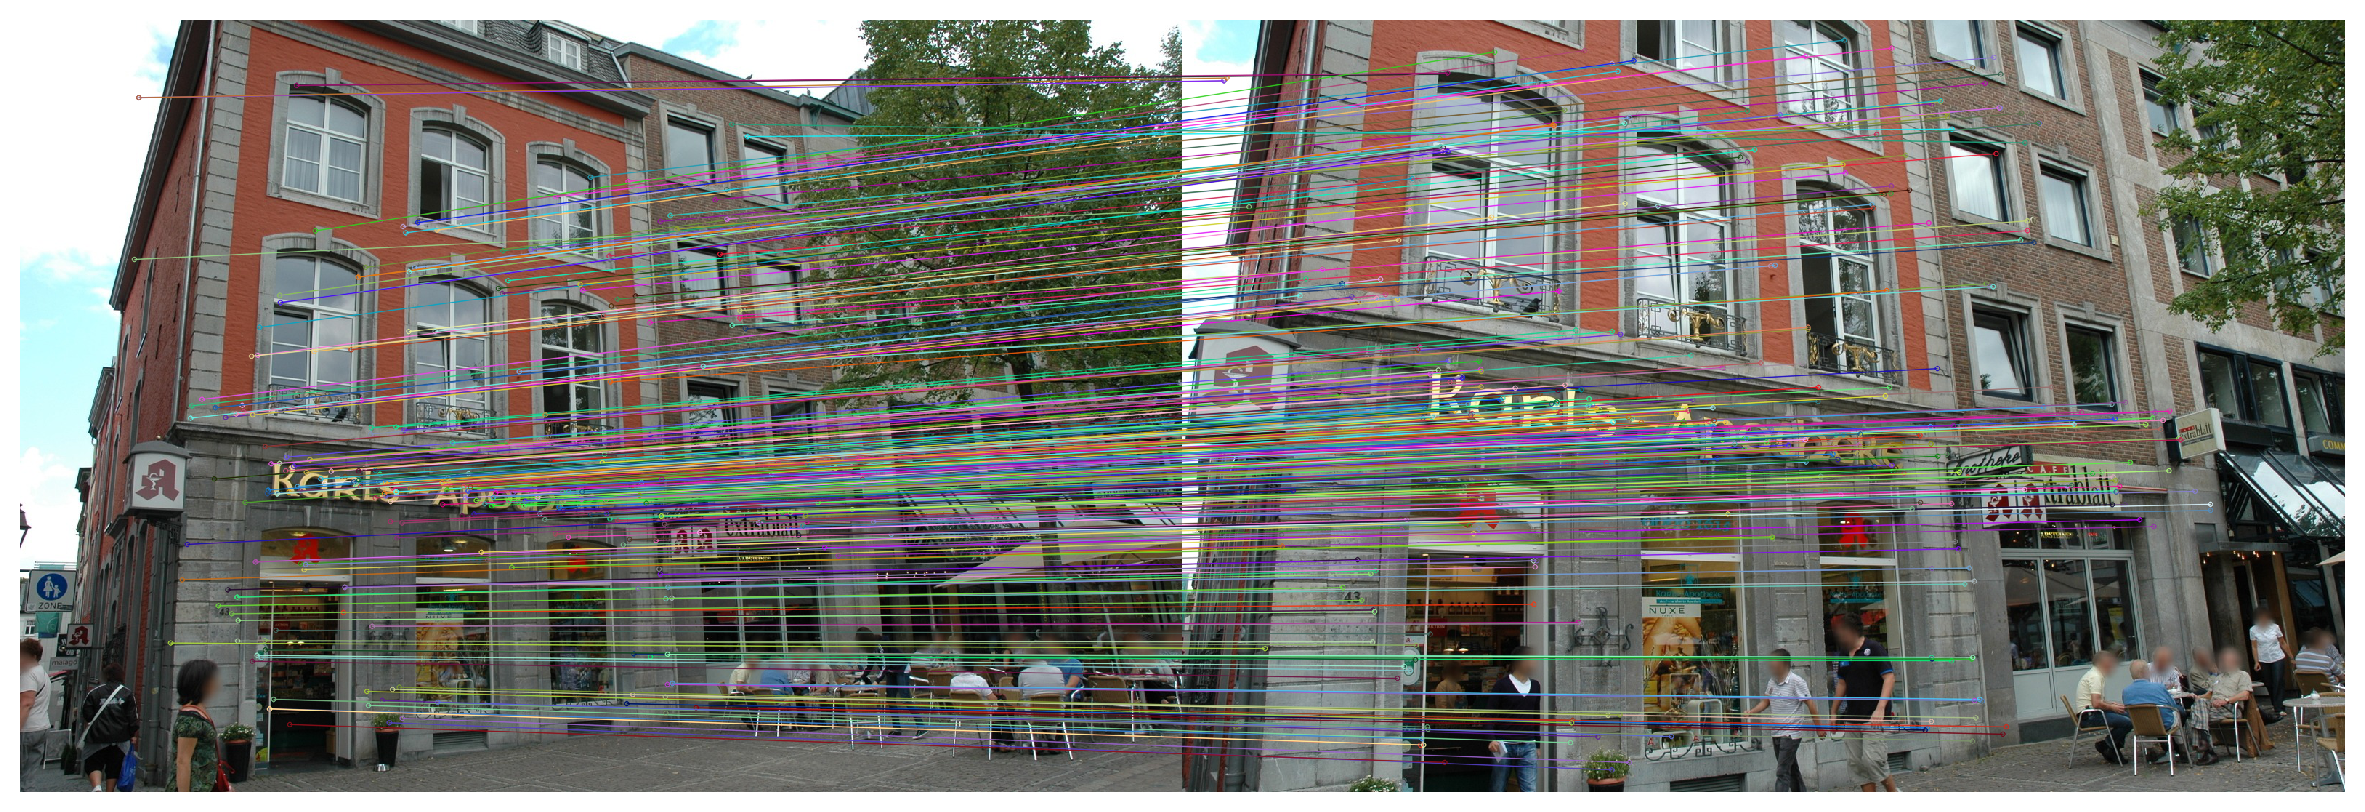

In [10]:
matches_cv = matches_to_cv(matches)
img3 = np.empty((max(image1.shape[0], image2.shape[0]), image1.shape[1] + image2.shape[1], 3), dtype=np.uint8)
cv2.drawMatches(image2,kpts_to_cv(k[1]),image1,kpts_to_cv(k[0]),matches_cv,outImg=img3,matchColor=None, singlePointColor=(255, 255, 255), flags=2)# **draw_params)
plt.figure(figsize=(15,15), dpi=200)
plt.imshow(img3)
plt.axis('off')

### Test effect if keypoints are not chosen freely

In [2]:
from evaluate import get_img_id, get_kpts_desc, get_cursor
from dataset_loaders.txt_to_db import get_images

In [8]:
if 'images' not in locals():
    images = get_images(path='../../data/images_points.db')
cursor = get_cursor('../../data/AachenDayNight/aachen.db')
db_id = get_img_id(cursor, 'db/2.jpg')
neighbor_kpts, neighbor_desc_colmap = get_kpts_desc(cursor, abs(db_id))
valid = images[abs(db_id)].point3D_ids > 0 
neighbor_kpts = neighbor_kpts[valid[:neighbor_kpts.shape[0]]] - 0.5
fixed_kpts = neighbor_kpts.copy()
print(fixed_kpts.shape)

(3032, 2)


In [13]:
descs_img2_fixed_kpts = model.get_features('../../data/AachenDayNight/images_upright/db/2.jpg', np.flip(fixed_kpts, axis=1))
print(descs_img2_fixed_kpts.shape)

(3032, 512)


In [14]:
matches_fixed_kpts = local_matcher.match(d[0], descs_img2_fixed_kpts)
print('{} matches found'.format(matches_fixed_kpts.shape[0]))

274 matches found


(-0.5, 3199.5, 1062.5, -0.5)

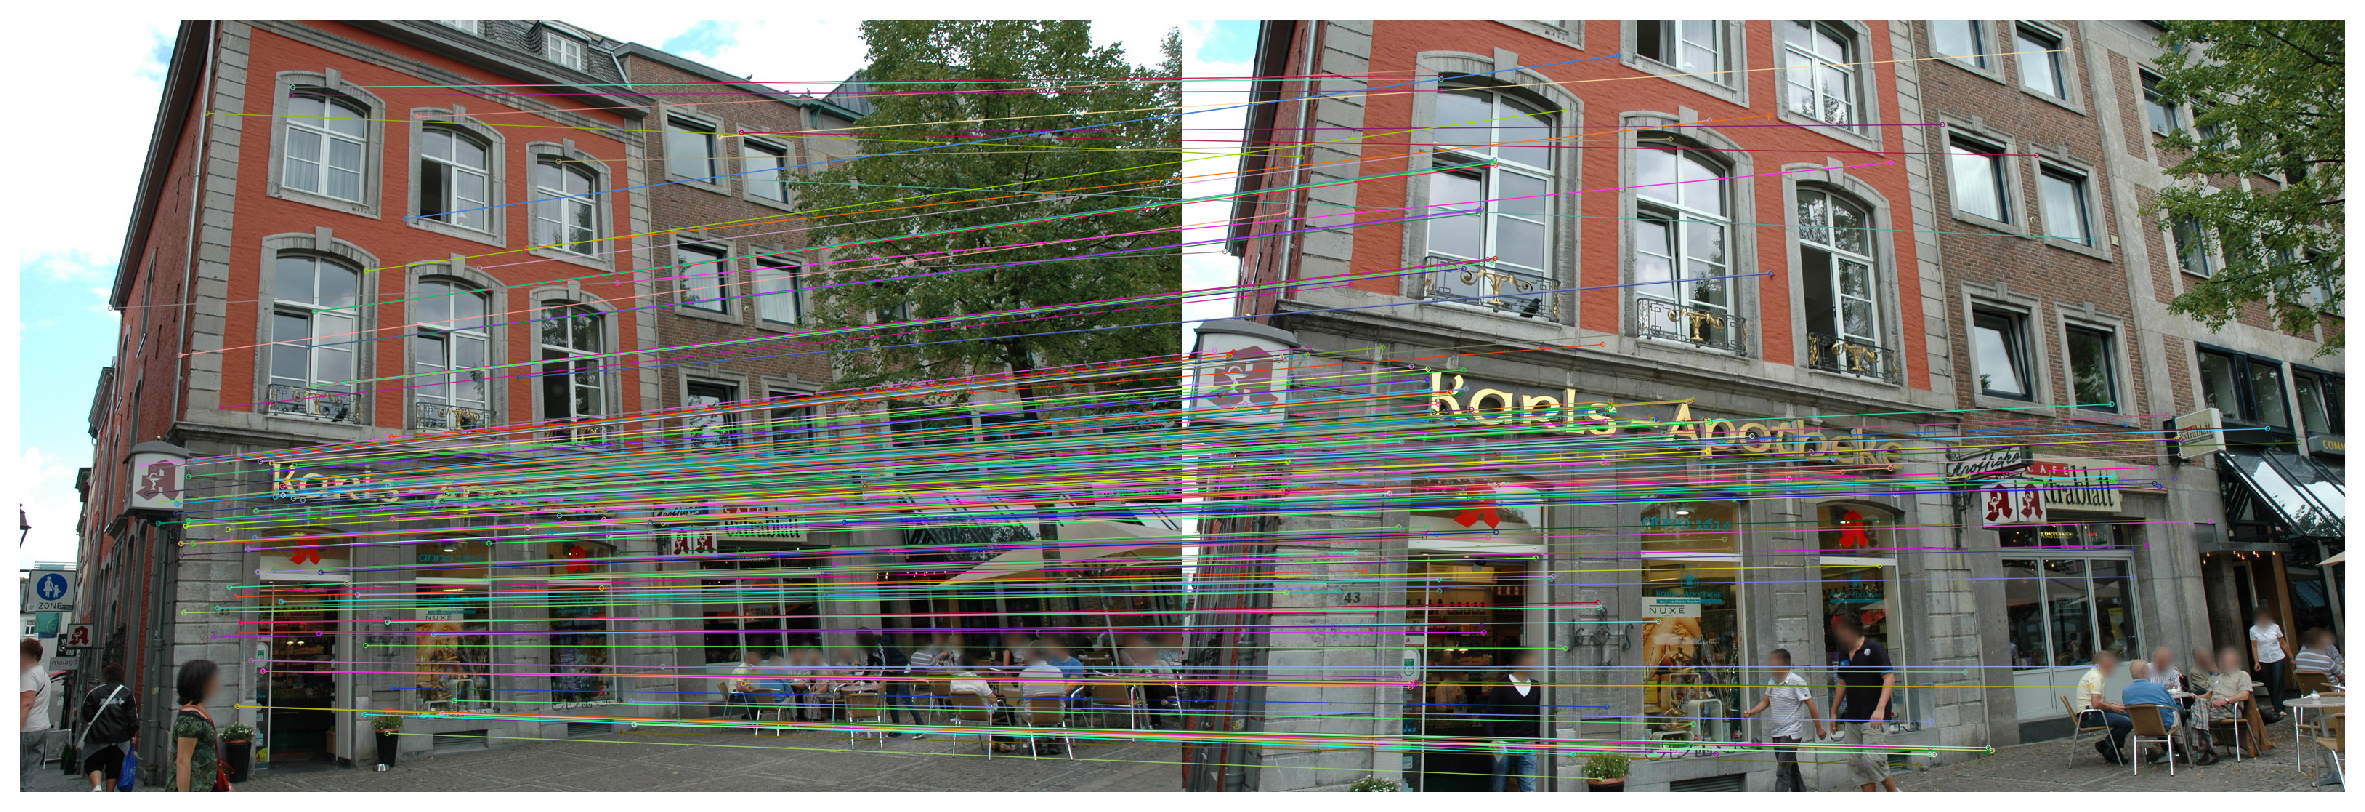

In [15]:
matches_cv_fixed = matches_to_cv(matches_fixed_kpts)
img3 = np.empty((max(image1.shape[0], image2.shape[0]), image1.shape[1] + image2.shape[1], 3), dtype=np.uint8)
cv2.drawMatches(image2,kpts_to_cv(fixed_kpts),image1,kpts_to_cv(k[0]),matches_cv_fixed,outImg=img3,matchColor=None, singlePointColor=(255, 255, 255), flags=2)# **draw_params)
plt.figure(figsize=(15,15), dpi=200)
plt.imshow(img3)
plt.axis('off')

### other tests

In [10]:
cursor = get_cursor('../../data/AachenDayNight/aachen.db')
cursor.execute('SELECT name FROM images WHERE image_id=?;',(53,))
#print(images[53].name)
#print(np.sum(images[abs(db_id)].point3D_ids > 0))
print(next(cursor))
neighbor_kpts, neighbor_desc_colmap = get_kpts_desc(cursor, 53)
valid = images[53].point3D_ids > 0 
neighbor_kpts = neighbor_kpts[valid[:neighbor_kpts.shape[0]]] - 0.5
print(neighbor_kpts.shape)
print(neighbor_desc_colmap.shape)

('db/1045.jpg',)
(6360, 2)
(8274, 128)


In [12]:
local_cursor = get_cursor('../../data/d2_descs.db')
#local_cursor.execute('CREATE INDEX tag_ids ON local_features (image_id);')
print('Cursor finished')
i = 53
t = time.time()
local_cursor.execute('SELECT cols, points, desc FROM local_features WHERE image_id=?;', (i,))
t = time.time() - t
print('Fetch finished in {:.2f}s'.format(t))
t = time.time()
c, p, d = next(local_cursor)
t = time.time() - t
print('Next finished in {:.2f}s'.format(t))

Cursor finished
Fetch finished in 0.66s
Next finished in 0.10s


In [13]:
print(i)
print(c)
k = np.frombuffer(p, dtype=np.float32).reshape(c, -1)
descs = np.frombuffer(d, dtype=np.float32).reshape(c, -1)
print(k.shape)
print(k.max(axis=0))
print(descs.shape)

53
6360
(6360, 2)
[1594.6748 1053.2917]
(6360, 512)


In [5]:
print(np.linalg.norm(descs, axis=1))

[6523.539  8401.701  8516.682  ... 8650.665  5688.3784 4782.688 ]
